- [x] Try to 

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [2]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((TDC, IDD))
Y = [0]*len(TDC) + [1]*len(IDD)
Y = np.asarray(Y)

In [3]:
print(X.shape)
print(Y.shape)

(17626, 14, 256)
(17626,)


## Create Spectrograms

In [4]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [29]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="complex128")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [30]:
X_scalogram = generate_scalogram2(X, 126, 64, 2)

100%|██████████| 17626/17626 [09:04<00:00, 32.38it/s]


In [31]:
X_scalogram.shape

(17626, 448, 128)

In [32]:
def plot_scalograms(data, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))
    
    print("Y label:", Y[sample_index])
    
    plt.rcParams['figure.figsize'] = 14, 30
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


Y label: 1


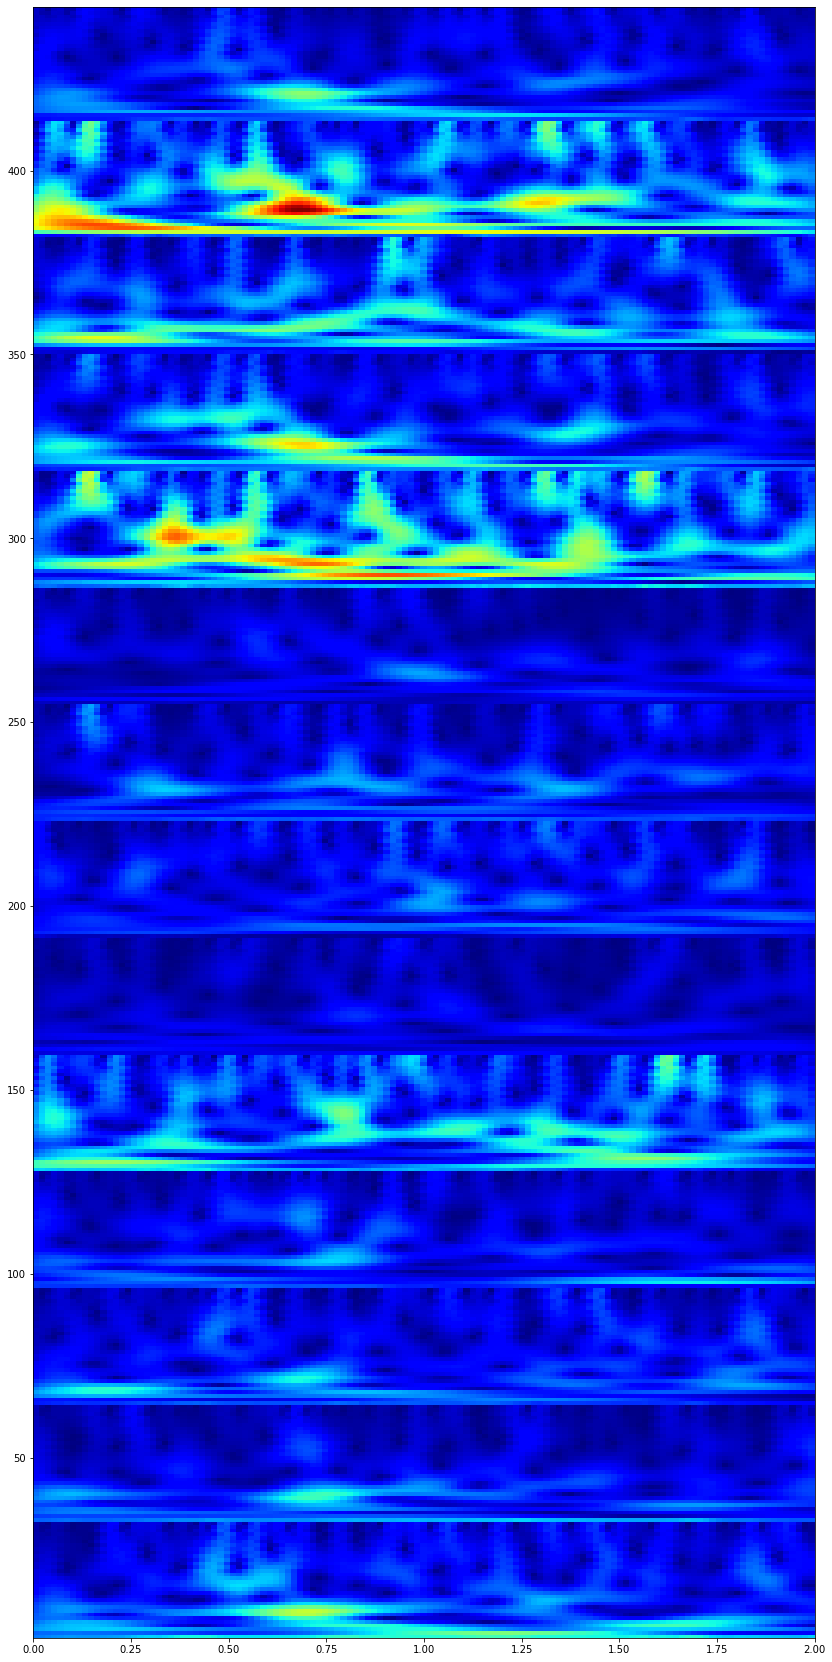

In [38]:
plot_scalograms(X_scalogram, 15000)

In [39]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1], X_scalogram.shape[2], 1)
X_scalogram_shaped.shape

(17626, 448, 128, 1)

## Test-Train split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, random_state=42)

In [41]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=22)

In [42]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
input_shape = X_train.shape[1:]

X_train shape: (14100, 448, 128, 1)
y_train shape: (14100,)
X_val shape: (3526, 448, 128, 1)
y_val shape: (3526,)


## Model

In [44]:
model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
#     keras.layers.Conv2D(12, (3, 3), padding="same", activation=tf.nn.relu),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
#     keras.layers.Dense(8, activation=tf.nn.relu),
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [45]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 448, 128, 8)       80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 224, 64, 8)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 64, 8)        32        
_________________________________________________________________
flatten_1 (Flatten)          (None, 114688)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 114689    
Total params: 114,801
Trainable params: 114,785
Non-trainable params: 16
_________________________________________________________________


In [47]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 14100 samples, validate on 3526 samples
Epoch 1/10
14100/14100 [==============================] - 182s 13ms/sample - loss: 0.1609 - accuracy: 0.9624 - val_loss: 0.5401 - val_accuracy: 0.9265
Epoch 2/10
14100/14100 [==============================] - 190s 13ms/sample - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0390 - val_accuracy: 0.9889
Epoch 3/10
 3328/14100 [======>.......................] - ETA: 2:51 - loss: 4.2185e-04 - accuracy: 1.0000

KeyboardInterrupt: 

* Music
    * Validation accuracy: 99.47%
    * Validation loss: 0.0161
* Rest
    * Validation accuracy: 99.53%
    * Validation loss: 0.0140


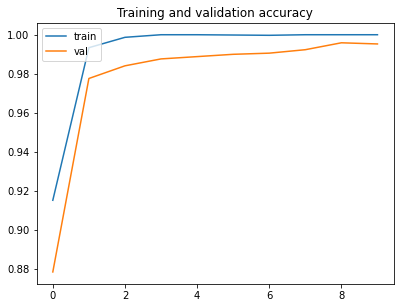

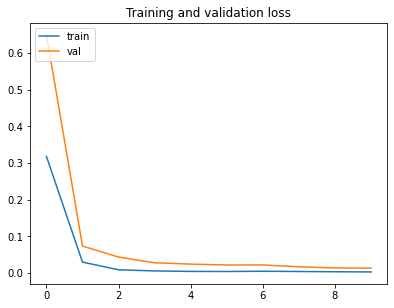

In [44]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
# plt.legend(['train'], loc='upper left')


plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')

In [45]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
#
# print('Test accuracy:', test_acc)
# print('Test loss:', test_loss)